# Variation due to `word2vec`'s random initialisation

 - fairly small at the word analogy task

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def get_exp_ids_for_reruns_of_word2vec(corpus='amazon_grouped-tagged', rep=0):
    query_dict = {
        'expansions__use_similarity': 0, 
          'expansions__neighbour_strategy':'linear',
          'expansions__vectors__dimensionality': 100, 
          'document_features_ev': 'AN+NN', 
          'document_features_tr': 'J+N+AN+NN', 
          'expansions__allow_overlap': False,
          'expansions__entries_of': None,
          'expansions__vectors__algorithm': 'word2vec',
          'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
          'expansions__vectors__unlabelled': 'wiki',
          'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
          'expansions__noise': 0,
          'expansions__use_similarity': 0, 
          'expansions__k':3,
          'expansions__vectors__unlabelled_percentage': 15,
          'expansions__vectors__rep': rep,
          'labelled':corpus}
    return Experiment.objects.filter(**query_dict).values_list('id', flat=True)

[[87, 88, 89, 90], [91, 92, 93, 94], [95, 96, 97, 98], [83, 84, 85, 86]]
['0', '1', '2', 'avg']
Calculating CI for exp 87
Calculating CI for exp 91
Calculating CI for exp 95
Calculating CI for exp 83
Calculating CI for exp 88
Calculating CI for exp 92
Calculating CI for exp 96
Calculating CI for exp 84
Calculating CI for exp 89
Calculating CI for exp 93
Calculating CI for exp 97
Calculating CI for exp 85
Calculating CI for exp 90
Calculating CI for exp 94
Calculating CI for exp 98
Calculating CI for exp 86


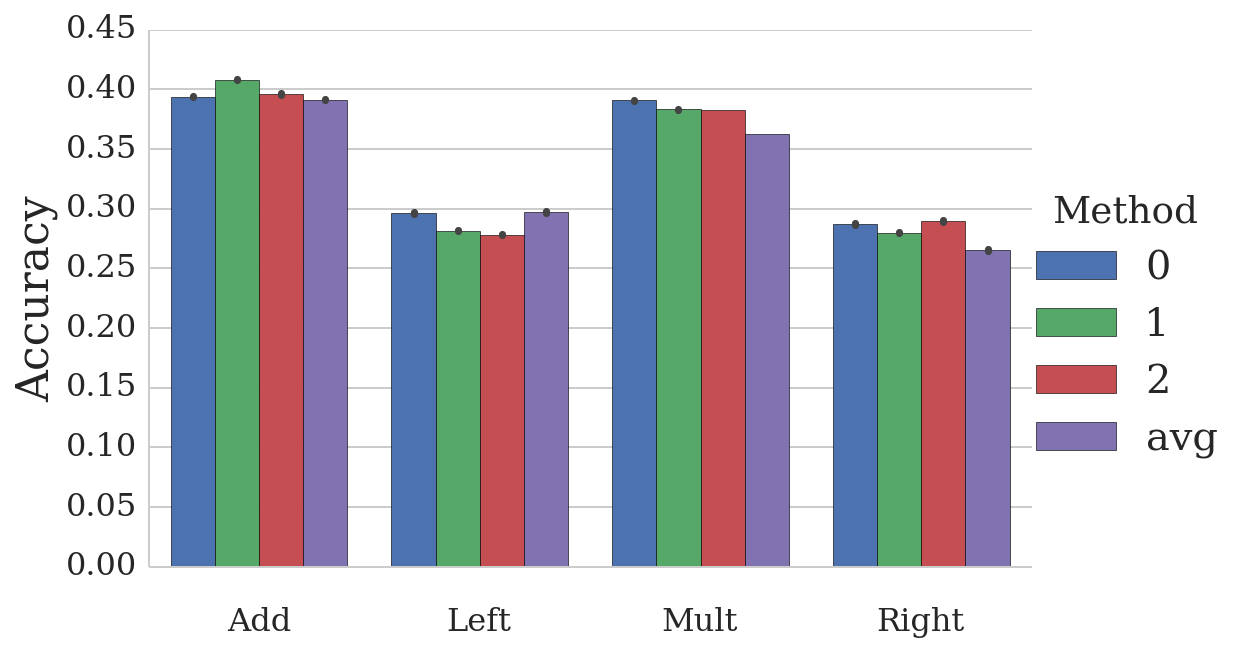

In [3]:
ids = [get_exp_ids_for_reruns_of_word2vec(rep=r) for r in [0, 1, 2, -1]]
print(ids)    
hue_order = pretty_names([x[0] for x in ids], 
                    name_format=['expansions__vectors__rep'])
hue_order[-1] = 'avg'
print(hue_order)
composers = pretty_names(ids[0], 
                    name_format=['expansions__vectors__composer'])

diff_plot_bar(ids, hue_order, composers, hue_order=hue_order)
plt.savefig('plot-w2v_random_init_var.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Compare unigram vectors between multiple runs
How many of the top `n` neighbour of some entries are the same accross multiple runs

In [9]:
from glob import glob
from discoutils.thesaurus_loader import Vectors as V
from random import sample
from itertools import combinations

pattern = '/mnt/lustre/scratch/inf/mmb28/FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.*'
files = sorted(glob(pattern))
thes = [V.from_tsv(f) for f in files]
for t in thes:
    t.init_sims(n_neighbors=100)

In [54]:
def dice(n1, n2):
    return 2 * len(set(n1) & set(n2))/ (len(n1) + len(n2))


def dice_loop(words, thes, log=False):
    dice_data = []
    for i,j in combinations(range(len(thes)), 2):
        pair_id = '%d-%r'%(i,j if j < 3 else 'A')
        if log:
            print('Doing pair', pair_id, flush=True)
        for num, word in enumerate(words):
            n1 = [x[0] for x in thes[i].get_nearest_neighbours(word)]
            n2 = [x[0] for x in thes[j].get_nearest_neighbours(word)]
            dice_data.append([pair_id, word, dice(n1, n2)])
    return dice_data

In [44]:
sampled_words = sample(list(thes[0].keys()), 5000)
dice_data = dice_loop(sampled_words, thes, log=True)

Doing pair 0-1


KeyboardInterrupt: 

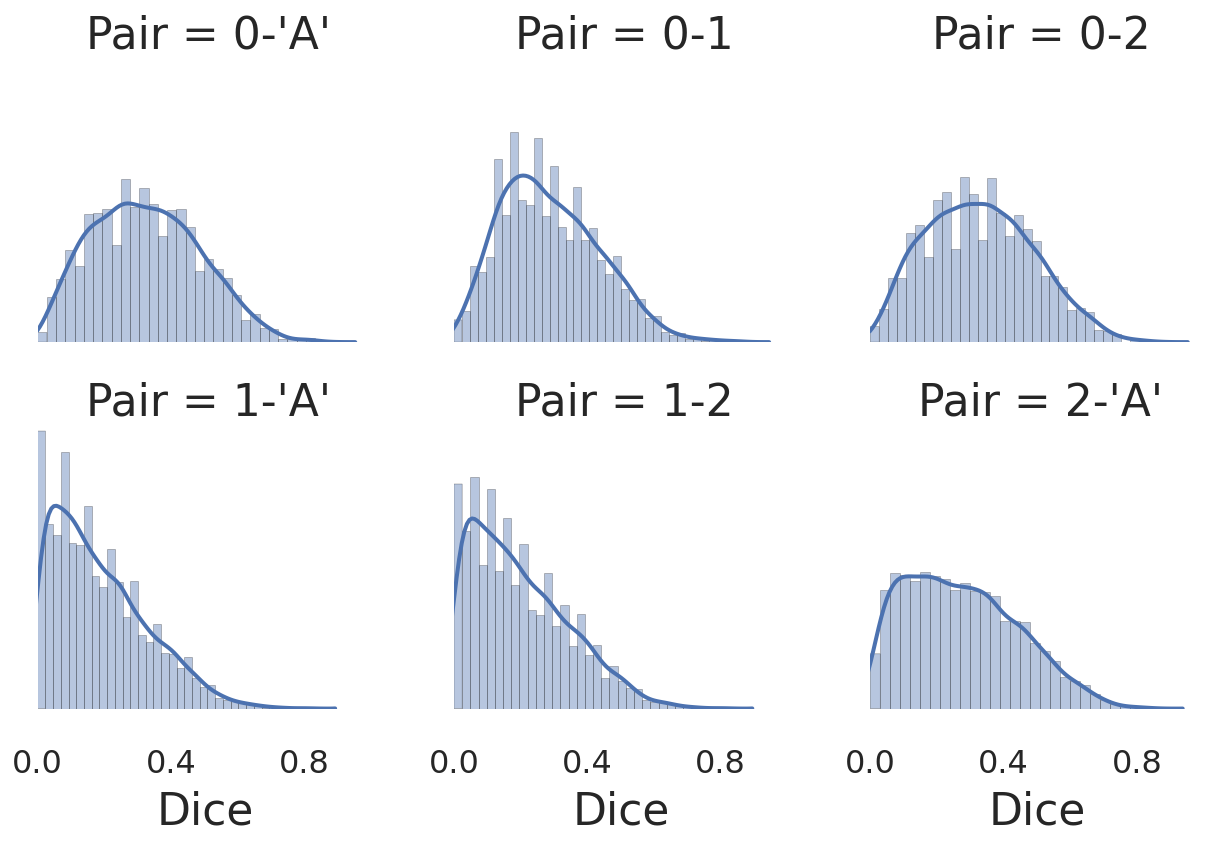

In [15]:
df3 = pd.DataFrame(dice_data, columns='Pair Word Dice'.split())
with sns.axes_style("white"):
    g = sns.FacetGrid(df3, col="Pair", col_wrap=3);
    g.map(sns.distplot, 'Dice', kde=True);

for ax in g.axes.flat:
    sparsify_axis_labels(ax)
    ax.set_xlim(0, 1.01)
    ax.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.savefig('plot-w2v_random_init_neigh_overlap.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Observations
Neighbours tend to be quite different over multiple runs, but the overall accuracy of the classification task changes very little
# Qualitative analysis
See below
Seems to me good neighbours (which seem sensible) tend to be the same across repeated runs

In [55]:
def multiway_dice(entry, thesauri):
    df = pd.DataFrame(dice_loop([entry], thesauri), columns='Pair Word Dice'.split())
    return df.Dice.mean()

In [61]:
df = compare_neighbours(thes[:-1], [0, 1, 2])#, words=['zhen/N', 'voracious/J'])
df['mw_dice'] = [multiway_dice(feat, thes[:-1]) for feat in df.index]
df.to_csv('compare_repeated_w2v.csv')
df.sort('mw_dice')

,0,1,2,mw_dice
wallach/N,"eisenberg/N, gwendolyn/N, ferrier/N, brittain/N","howes/N, molloy/N, dowling/N, enright/N","eisenberg/N, alwyn/N, blankenship/N, bly/N",0.096667
muskoka/N,"taupo/N, wyre/N, whangarei/N, wairarapa/N","chilliwack/N, kapuskasing/N, manawatu/N, lillo...","queensbury/N, lewistown/N, kogarah/N, wheatfie...",0.113333
pun/N,"colloquialism/N, in-joke/N, wordplay/N, vamp/N","wordplay/N, similar-sounding/J, made-up/J, che...","take/N, verge/V, interjection/N, derisive/J",0.236667
appomattox/N,"spotsylvania/N, perryville/N, brandywine/N, an...","spotsylvania/N, perryville/N, warrenton/N, vic...","spotsylvania/N, monocacy/N, chickamauga/N, vic...",0.280000
offshoot/N,"off-shoot/N, scion/N, hotb/V, amalgam/N","off-shoot/N, amalgam/N, outgrowth/N, melding/N","off-shoot/N, microcosm/N, conglomeration/N, ou...",0.283333
eligibility/N,"admission/N, eligible/N, applicant/N, licensure/N","eligible/N, admission/N, reimbursement/N, mand...","admission/N, requirement/N, eligible/N, regist...",0.350000
undamaged/J,"breastwork/N, sandbag/N, sea-going/J, foremast/N","damaged/J, immobilise/V, breastwork/N, seawort...","undefended/J, mainmast/N, emplace/V, uninjured/J",0.353333
lai/N,"dang/N, hung/N, chu/N, mei/N","fong/N, lam/N, phong/N, nai/N","dong/N, geng/N, chai/N, hoi/N",0.436667
highest-rated/J,"most-watched/J, longest-running/J, top-rated/J...","most-watched/J, longest-running/J, top-rated/J...","most-watched/J, prime-time/N, top-rated/J, pri...",0.543333
ailment/N,"incurable/J, asthma/N, rheumatic/J, pain/N","disease/N, sufferer/N, asthma/N, pancreatitis/N","disease/N, incurable/J, debilitating/J, life-t...",0.553333
